In [4]:
"""
이더리움 트레이딩 백테스팅 시스템
완전한 구현 - 4가지 전략 모두 포함
"""

from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')


@dataclass
class Config:
    market_data_path: Path = Path("../macro_data/macro_data/macro_crypto_data.csv")
    model_results_base: Path = Path("../model_results/2025-10-26")
    output_dir: Path = Path("backtest_results_comprehensive")
    
    folds: List[int] = None
    models: List[str] = None
    position_strategies: List[str] = None
    confidence_thresholds: List[float] = None
    
    initial_capital: float = 1_000_000
    spot_trading_fee: float = 0.004
    spot_slippage: float = 0.0005
    
    futures_leverage: int = 3
    futures_taker_fee: float = 0.0005
    futures_funding_rate: float = 0.0001
    futures_slippage: float = 0.0003
    futures_stop_loss: float = 0.05
    futures_take_profit: float = 0.10
    
    swing_entry_confidence: float = 0.30
    swing_entry_trend: float = 0.35
    swing_stop_loss: float = 0.03
    swing_take_profit: float = 0.15
    swing_exit_trend: float = 0.15
    swing_max_holding: int = 20
    
    def __post_init__(self):
        if self.folds is None:
            self.folds = list(range(1, 9))
        
        if self.models is None:
            self.models = ['RandomForest', 'LightGBM', 'XGBoost', 'SVM', 'LogisticRegression', 'NaiveBayes', 
                               'KNN', 'AdaBoost', 'CatBoost', 'DecisionTree', 'ExtraTrees', 'Bagging', 
                               'GradientBoosting', 'HistGradientBoosting', 'StackingEnsemble', 'VotingHard', 
                               'VotingSoft', 'MLP', 'LSTM', 'BiLSTM', 'GRU', 'TCN', 'CNN_LSTM', 
                               'LSTM_Attention', 'DTW_LSTM', 'VMD_Hybrid', 'EMD_LSTM', 'Hybrid_LSTM_GRU', 
                               'Residual_LSTM']
        
        if self.position_strategies is None:
            self.position_strategies = ['fixed_10', 'fixed_30', 'fixed_50']
        
        if self.confidence_thresholds is None:
            self.confidence_thresholds = [0.0, 0.2, 0.3]
        
        self.output_dir.mkdir(parents=True, exist_ok=True)


class DataLoader:
    def __init__(self, config: Config):
        self.config = config
        self.market_data = None
        self.fold_info = {
            1: {'test_start': '2022-12-07', 'test_end': '2023-05-05'},
            2: {'test_start': '2023-05-06', 'test_end': '2023-10-02'},
            3: {'test_start': '2023-10-03', 'test_end': '2024-02-29'},
            4: {'test_start': '2024-03-01', 'test_end': '2024-07-28'},
            5: {'test_start': '2024-07-29', 'test_end': '2024-12-25'},
            6: {'test_start': '2024-12-26', 'test_end': '2025-05-24'},
            7: {'test_start': '2025-05-25', 'test_end': '2025-10-21'},
            8: {'test_start': '2025-01-01', 'test_end': '2025-10-21'}
        }
    
    def load_market_data(self):
        if self.market_data is None:
            df = pd.read_csv(self.config.market_data_path)
            df['date'] = pd.to_datetime(df['date'])
            self.market_data = df[['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close']].copy()
        return self.market_data
    
    def get_fold_market_data(self, fold: int):
        market_df = self.load_market_data()
        cfg = self.fold_info[fold]
        start = pd.to_datetime(cfg['test_start'])
        end = pd.to_datetime(cfg['test_end'])
        mask = (market_df['date'] >= start) & (market_df['date'] <= end)
        return market_df[mask].copy().reset_index(drop=True)
    
    def load_predictions(self, fold: int, model: str):
        pred_path = (
            self.config.model_results_base / 
            "fold_results/direction" / 
            f"fold_{fold}_walk_forward_rolling_reverse" / 
            f"{model}_predictions.csv"
        )
        
        if not pred_path.exists():
            raise FileNotFoundError(f"Not found: {pred_path}")
        
        df = pd.read_csv(pred_path)
        df['date'] = pd.to_datetime(df['date'])
        return df[['date', 'pred_direction', 'confidence', 'max_proba']].copy()


class MetricsCalculator:
    @staticmethod
    def calculate(trades, daily_capital, final_capital, initial_capital, 
                 buy_hold_return, strategy_info):
        metrics = strategy_info.copy()
        total_return = (final_capital / initial_capital - 1) * 100
        alpha = total_return - buy_hold_return
        
        trades_with_pnl = [t for t in trades if 'pnl' in t]
        if trades_with_pnl:
            wins = [t for t in trades_with_pnl if t['pnl'] > 0]
            win_rate = len(wins) / len(trades_with_pnl)
        else:
            win_rate = 0
        
        peak = initial_capital
        max_dd = 0
        for capital in daily_capital:
            peak = max(peak, capital)
            if peak > 0:
                dd = (peak - capital) / peak
                max_dd = max(max_dd, dd)
        
        metrics.update({
            'total_return_pct': total_return,
            'alpha_pct': alpha,
            'final_capital': final_capital,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'max_drawdown': max_dd
        })
        
        return metrics


class PositionSizer:
    @staticmethod
    def calculate(strategy, capital, confidence):
        if strategy == 'fixed_10':
            return capital * 0.10
        elif strategy == 'fixed_30':
            return capital * 0.30
        elif strategy == 'fixed_50':
            return capital * 0.50
        return capital * 0.10


class BuyHoldStrategy:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, fold):
        initial = self.config.initial_capital
        entry_price = market_df.iloc[0]['ETH_Open']
        exit_price = market_df.iloc[-1]['ETH_Close']
        
        fee = initial * self.config.spot_trading_fee
        eth_amount = (initial - fee) / entry_price
        
        final_value = eth_amount * exit_price
        final_fee = final_value * self.config.spot_trading_fee
        final_capital = final_value - final_fee
        
        daily_capital = [eth_amount * p for p in market_df['ETH_Close']]
        
        trades = [{'pnl': final_capital - initial}]
        
        info = {
            'fold': fold,
            'strategy': 'Buy & Hold',
            'model': 'N/A',
            'position_strategy': 'N/A',
            'trading_method': 'buy_hold',
            'confidence_threshold': 0.0
        }
        
        total_return = (final_capital / initial - 1) * 100
        return MetricsCalculator.calculate(
            trades, daily_capital, final_capital, initial, total_return, info
        )


class SpotDayTrading:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        cash = self.config.initial_capital
        eth = 0
        trades = []
        daily_capital = []
        last_buy = 0
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for _, row in merged.iterrows():
            if row['confidence'] < conf_threshold:
                daily_capital.append(cash + eth * row['ETH_Close'])
                continue
            
            price = row['ETH_Open']
            
            if row['pred_direction'] == 1 and eth == 0:
                size = PositionSizer.calculate(pos_strategy, cash, row['confidence'])
                if size > 0:
                    fee = size * self.config.spot_trading_fee
                    eth = (size - fee) / price
                    cash -= size
                    last_buy = size
            
            elif row['pred_direction'] == 0 and eth > 0:
                value = eth * price
                fee = value * self.config.spot_trading_fee
                pnl = (value - fee) - last_buy
                cash += (value - fee)
                trades.append({'pnl': pnl})
                eth = 0
            
            daily_capital.append(cash + eth * row['ETH_Close'])
        
        if eth > 0:
            final_price = merged.iloc[-1]['ETH_Close']
            cash += eth * final_price
        
        info = {
            'fold': fold,
            'strategy': 'Spot Day Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'spot_day',
            'confidence_threshold': conf_threshold
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, cash, self.config.initial_capital, bh_return, info
        )


class SpotSwingTrading:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        cash = self.config.initial_capital
        eth = 0
        in_position = False
        entry_price = 0
        entry_value = 0
        holding_days = 0
        
        trades = []
        daily_capital = []
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for idx, row in merged.iterrows():
            if not in_position:
                trend = self._trend(merged, idx)
                if (row['pred_direction'] == 1 and 
                    row['confidence'] > self.config.swing_entry_confidence and
                    trend > self.config.swing_entry_trend):
                    
                    entry_price = row['ETH_Open']
                    size = PositionSizer.calculate(pos_strategy, cash, row['confidence'])
                    if size > 0:
                        fee = size * self.config.spot_trading_fee
                        eth = (size - fee) / entry_price
                        cash -= size
                        entry_value = size
                        in_position = True
                        holding_days = 0
            else:
                holding_days += 1
                current_return = (row['ETH_Close'] / entry_price - 1)
                trend = self._trend(merged, idx)
                
                should_exit = (
                    current_return <= -self.config.swing_stop_loss or
                    current_return >= self.config.swing_take_profit or
                    trend < self.config.swing_exit_trend or
                    row['pred_direction'] == 0 or
                    holding_days >= self.config.swing_max_holding or
                    idx == len(merged) - 1
                )
                
                if should_exit:
                    exit_price = row['ETH_Close']
                    value = eth * exit_price
                    fee = value * self.config.spot_trading_fee
                    pnl = (value - fee) - entry_value
                    cash += (value - fee)
                    trades.append({'pnl': pnl})
                    eth = 0
                    in_position = False
            
            daily_capital.append(cash + eth * row['ETH_Close'])
        
        info = {
            'fold': fold,
            'strategy': 'Spot Swing Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'spot_swing',
            'confidence_threshold': conf_threshold
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, cash, self.config.initial_capital, bh_return, info
        )
    
    def _trend(self, df, idx):
        start = max(0, idx - 4)
        window = df.iloc[start:idx+1]
        if len(window) == 0:
            return 0
        up_ratio = window['pred_direction'].sum() / len(window)
        avg_conf = window['confidence'].mean()
        return up_ratio * avg_conf


class FuturesDayTrading:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        capital = self.config.initial_capital
        trades = []
        daily_capital = []
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for _, row in merged.iterrows():
            if row['confidence'] < conf_threshold:
                daily_capital.append(capital)
                continue
            
            entry = row['ETH_Open']
            exit = row['ETH_Close']
            
            if pd.isna(entry) or pd.isna(exit) or entry <= 0 or exit <= 0:
                daily_capital.append(capital)
                continue
            
            margin = PositionSizer.calculate(pos_strategy, capital, row['confidence'])
            if margin <= 0:
                daily_capital.append(capital)
                continue
            
            pos_value = margin * self.config.futures_leverage
            
            if row['pred_direction'] == 1:
                direction = 1
            else:
                direction = -1
            
            price_change = (exit / entry - 1) * direction
            
            fee = pos_value * self.config.futures_taker_fee * 2
            funding = pos_value * self.config.futures_funding_rate * 3
            
            pnl = pos_value * price_change - fee - funding
            
            if abs(price_change) >= (1 / self.config.futures_leverage):
                pnl = -margin
            
            capital += pnl
            trades.append({'pnl': pnl})
            daily_capital.append(capital)
        
        info = {
            'fold': fold,
            'strategy': 'Futures Day Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'futures_day',
            'confidence_threshold': conf_threshold
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, capital, self.config.initial_capital, bh_return, info
        )


class FuturesSwingTrading:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        capital = self.config.initial_capital
        in_position = False
        side = None
        entry_price = 0
        margin = 0
        holding_days = 0
        
        trades = []
        daily_capital = []
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for idx, row in merged.iterrows():
            if not in_position:
                trend = self._trend(merged, idx)
                if (row['confidence'] > self.config.swing_entry_confidence and
                    abs(trend) > self.config.swing_entry_trend):
                    
                    if row['pred_direction'] == 1:
                        side = 'LONG'
                    else:
                        side = 'SHORT'
                    
                    entry_price = row['ETH_Open']
                    margin = PositionSizer.calculate(pos_strategy, capital, row['confidence'])
                    if margin > 0:
                        in_position = True
                        holding_days = 0
            else:
                holding_days += 1
                if side == 'LONG':
                    ret = (row['ETH_Close'] / entry_price - 1)
                else:
                    ret = -(row['ETH_Close'] / entry_price - 1)
                
                trend = self._trend(merged, idx)
                should_exit = (
                    ret <= -self.config.swing_stop_loss or
                    ret >= self.config.swing_take_profit or
                    abs(trend) < self.config.swing_exit_trend or
                    holding_days >= self.config.swing_max_holding or
                    idx == len(merged) - 1
                )
                
                if should_exit:
                    exit_price = row['ETH_Close']
                    pos_value = margin * self.config.futures_leverage
                    
                    if side == 'LONG':
                        change = (exit_price / entry_price - 1)
                    else:
                        change = -(exit_price / entry_price - 1)
                    
                    fee = pos_value * self.config.futures_taker_fee * 2
                    funding = pos_value * self.config.futures_funding_rate * 3 * holding_days
                    
                    pnl = pos_value * change - fee - funding
                    
                    if abs(change) >= (1 / self.config.futures_leverage):
                        pnl = -margin
                    
                    capital += pnl
                    trades.append({'pnl': pnl})
                    in_position = False
            
            daily_capital.append(capital)
        
        info = {
            'fold': fold,
            'strategy': 'Futures Swing Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'futures_swing',
            'confidence_threshold': conf_threshold
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, capital, self.config.initial_capital, bh_return, info
        )
    
    def _trend(self, df, idx):
        start = max(0, idx - 4)
        window = df.iloc[start:idx+1]
        if len(window) == 0:
            return 0
        up_ratio = window['pred_direction'].sum() / len(window)
        avg_conf = window['confidence'].mean()
        return up_ratio * avg_conf


class BacktestEngine:
    def __init__(self, config):
        self.config = config
        self.data_loader = DataLoader(config)
        self.results = []
    
    def run_all_backtests(self):
        print("백테스팅 시작")
        print(f"Folds: {len(self.config.folds)}")
        print(f"Models: {len(self.config.models)}")
        print(f"Position: {len(self.config.position_strategies)}")
        print(f"Confidence: {len(self.config.confidence_thresholds)}")
        
        total = (
            len(self.config.folds) * 
            len(self.config.models) * 
            len(self.config.position_strategies) * 
            len(self.config.confidence_thresholds) * 4
        )
        print(f"예상 백테스트 수: {total}")
        
        for fold in self.config.folds:
            print(f"\nFold {fold} 처리 중...")
            
            market_df = self.data_loader.get_fold_market_data(fold)
            
            buy_hold = BuyHoldStrategy(self.config)
            bh_result = buy_hold.backtest(market_df, fold)
            bh_return = bh_result['total_return_pct']
            self.results.append(bh_result)
            
            for model in self.config.models:
                try:
                    pred_df = self.data_loader.load_predictions(fold, model)
                except FileNotFoundError:
                    continue
                
                for pos in self.config.position_strategies:
                    for conf in self.config.confidence_thresholds:
                        
                        spot_day = SpotDayTrading(self.config)
                        r = spot_day.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
                        
                        spot_swing = SpotSwingTrading(self.config)
                        r = spot_swing.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
                        
                        futures_day = FuturesDayTrading(self.config)
                        r = futures_day.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
                        
                        futures_swing = FuturesSwingTrading(self.config)
                        r = futures_swing.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
            
            print(f"Fold {fold} 완료")
        
        print("\n백테스팅 완료")
        self.save_results()
        self.analyze_results()
    
    def save_results(self):
        df = pd.DataFrame(self.results)
        df.to_csv(self.config.output_dir / 'backtest_results_full.csv', index=False)
        print(f"\n결과 저장: {self.config.output_dir}")
    
    def analyze_results(self):
        df = pd.DataFrame(self.results)
        
        print("\n" + "="*80)
        print("백테스팅 결과 요약")
        print("="*80)
        
        bh = df[df['strategy'] == 'Buy & Hold']['total_return_pct'].mean()
        print(f"\nBuy & Hold: {bh:+.2f}%")
        
        trading = df[df['strategy'] != 'Buy & Hold']
        print(f"트레이딩 평균 Alpha: {trading['alpha_pct'].mean():+.2f}%")
        print(f"Alpha > 0: {(trading['alpha_pct'] > 0).sum()}/{len(trading)}")
        
        print("\n전략별 평균 Alpha:")
        by_method = trading.groupby('trading_method')['alpha_pct'].mean().sort_values(ascending=False)
        print(by_method)
        
        print("\n상위 10개:")
        best = trading.nlargest(10, 'alpha_pct')
        print(best[['fold', 'model', 'strategy', 'position_strategy', 
                   'confidence_threshold', 'alpha_pct', 'num_trades']])


if __name__ == "__main__":
    config = Config()
    engine = BacktestEngine(config)
    engine.run_all_backtests()


백테스팅 시작
Folds: 8
Models: 29
Position: 3
Confidence: 3
예상 백테스트 수: 8352

Fold 1 처리 중...
Fold 1 완료

Fold 2 처리 중...
Fold 2 완료

Fold 3 처리 중...
Fold 3 완료

Fold 4 처리 중...
Fold 4 완료

Fold 5 처리 중...
Fold 5 완료

Fold 6 처리 중...
Fold 6 완료

Fold 7 처리 중...
Fold 7 완료

Fold 8 처리 중...
Fold 8 완료

백테스팅 완료

결과 저장: backtest_results_comprehensive

백테스팅 결과 요약

Buy & Hold: +22.50%
트레이딩 평균 Alpha: -22.03%
Alpha > 0: 3025/7308

전략별 평균 Alpha:
trading_method
futures_swing    -9.243749
spot_swing      -19.971063
spot_day        -22.356313
futures_day     -36.533270
Name: alpha_pct, dtype: float64

상위 10개:
      fold          model             strategy position_strategy  \
5936     6         BiLSTM  Futures Day Trading          fixed_50   
4891     5         BiLSTM  Futures Day Trading          fixed_50   
4927     5            GRU  Futures Day Trading          fixed_50   
6116     6       DTW_LSTM  Futures Day Trading          fixed_50   
5924     6         BiLSTM  Futures Day Trading          fixed_30   
3882     4

트레이딩 실패 원인 심층 분석 시작

분석 1: 수익률 크기별 예측 정확도

수익률 구간별 예측 정확도:
                   정확도  평균신뢰도   거래수
return_category                    
대폭락(<-5%)        0.570  0.260   523
폭락(-5~-3%)       0.623  0.237   795
하락(-3~-1%)       0.618  0.237  1955
횡보(-1~1%)        0.607  0.222  4006
상승(1~3%)         0.601  0.233  2126
급등(3~5%)         0.656  0.236   841
대급등(>5%)         0.593  0.259   674

저장: analysis_1_accuracy_by_return.png

분석 2: 틀린 예측의 비용

틀린 예측 유형별 비용:
                           cost                daily_return
                           mean      sum count         mean
error_type                                                 
False Negative (하락 예측 실패)  3.01  6445.80  2145         0.31
False Positive (상승 예측 실패)  3.15  6656.95  2113         0.01

저장: analysis_2_error_cost.png

분석 3: 청산 위험 분석 (레버리지 3배 가정)

일중 변동성 통계:
count    2907.000000
mean        5.801597
std         4.160359
min         0.355233
25%         3.110175
50%         4.691496
75%         7.258463
max        43.914458
Name: 

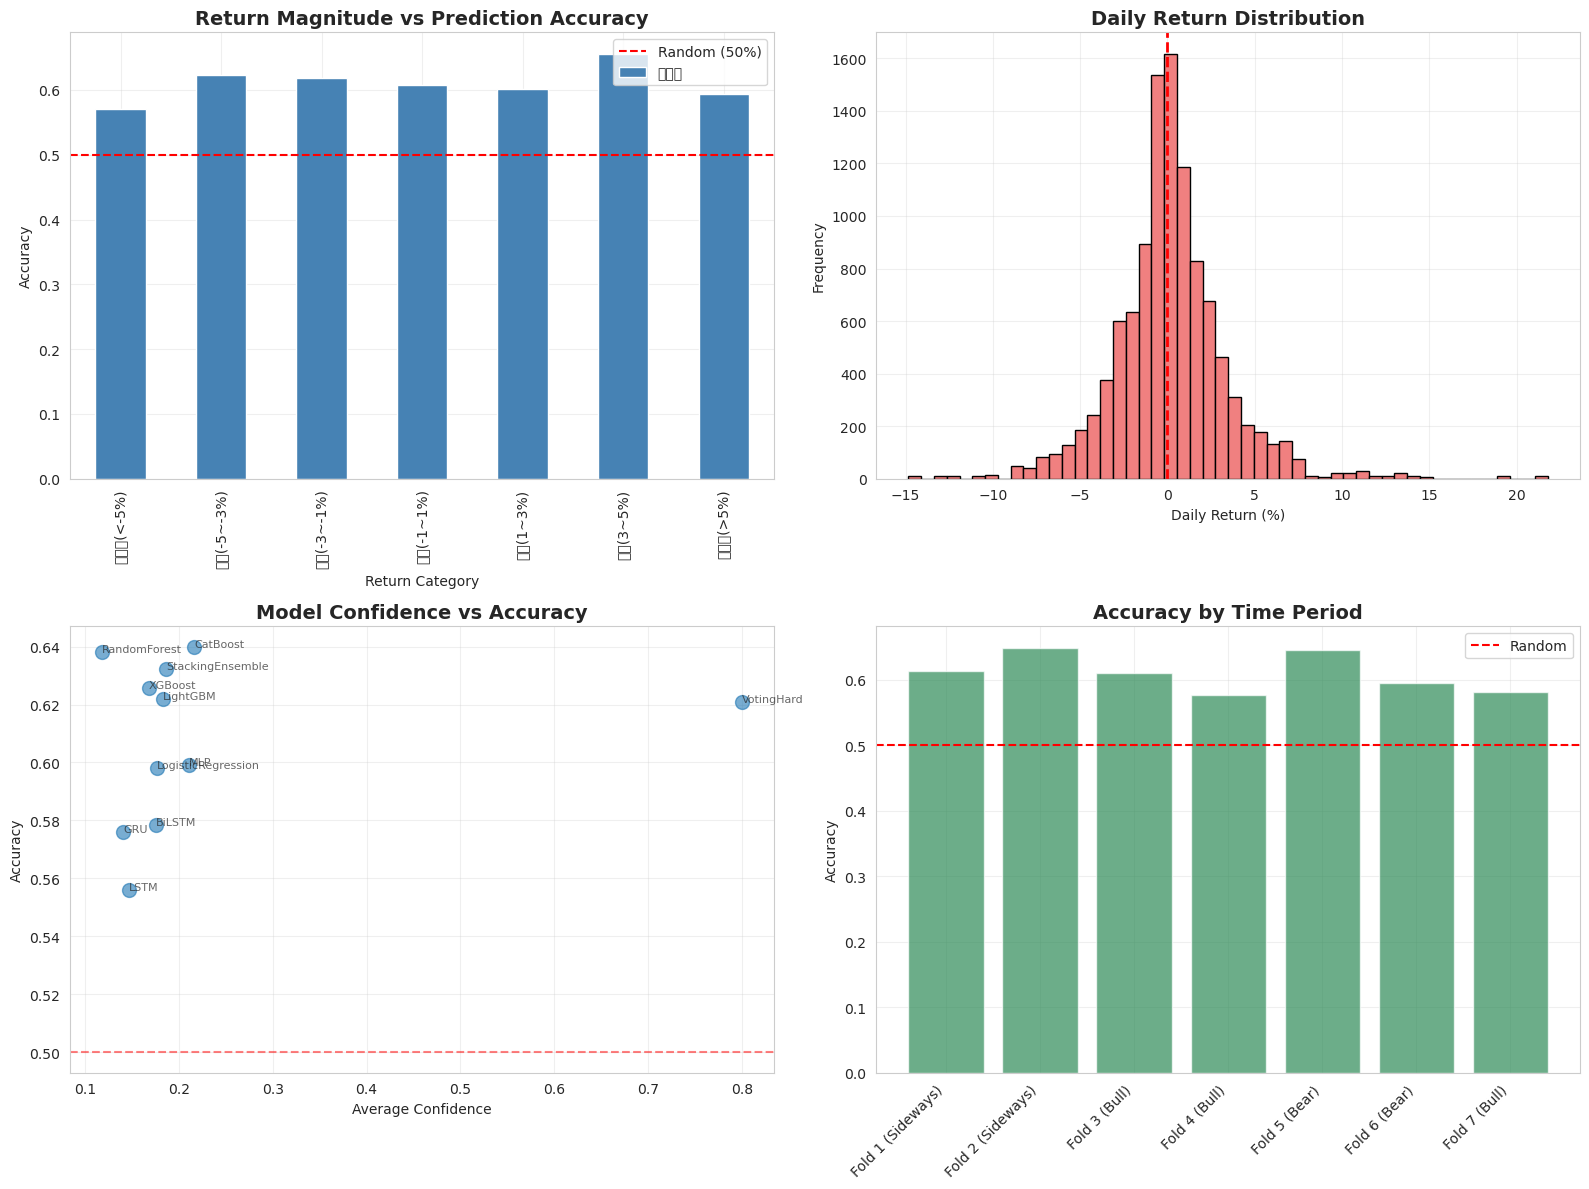

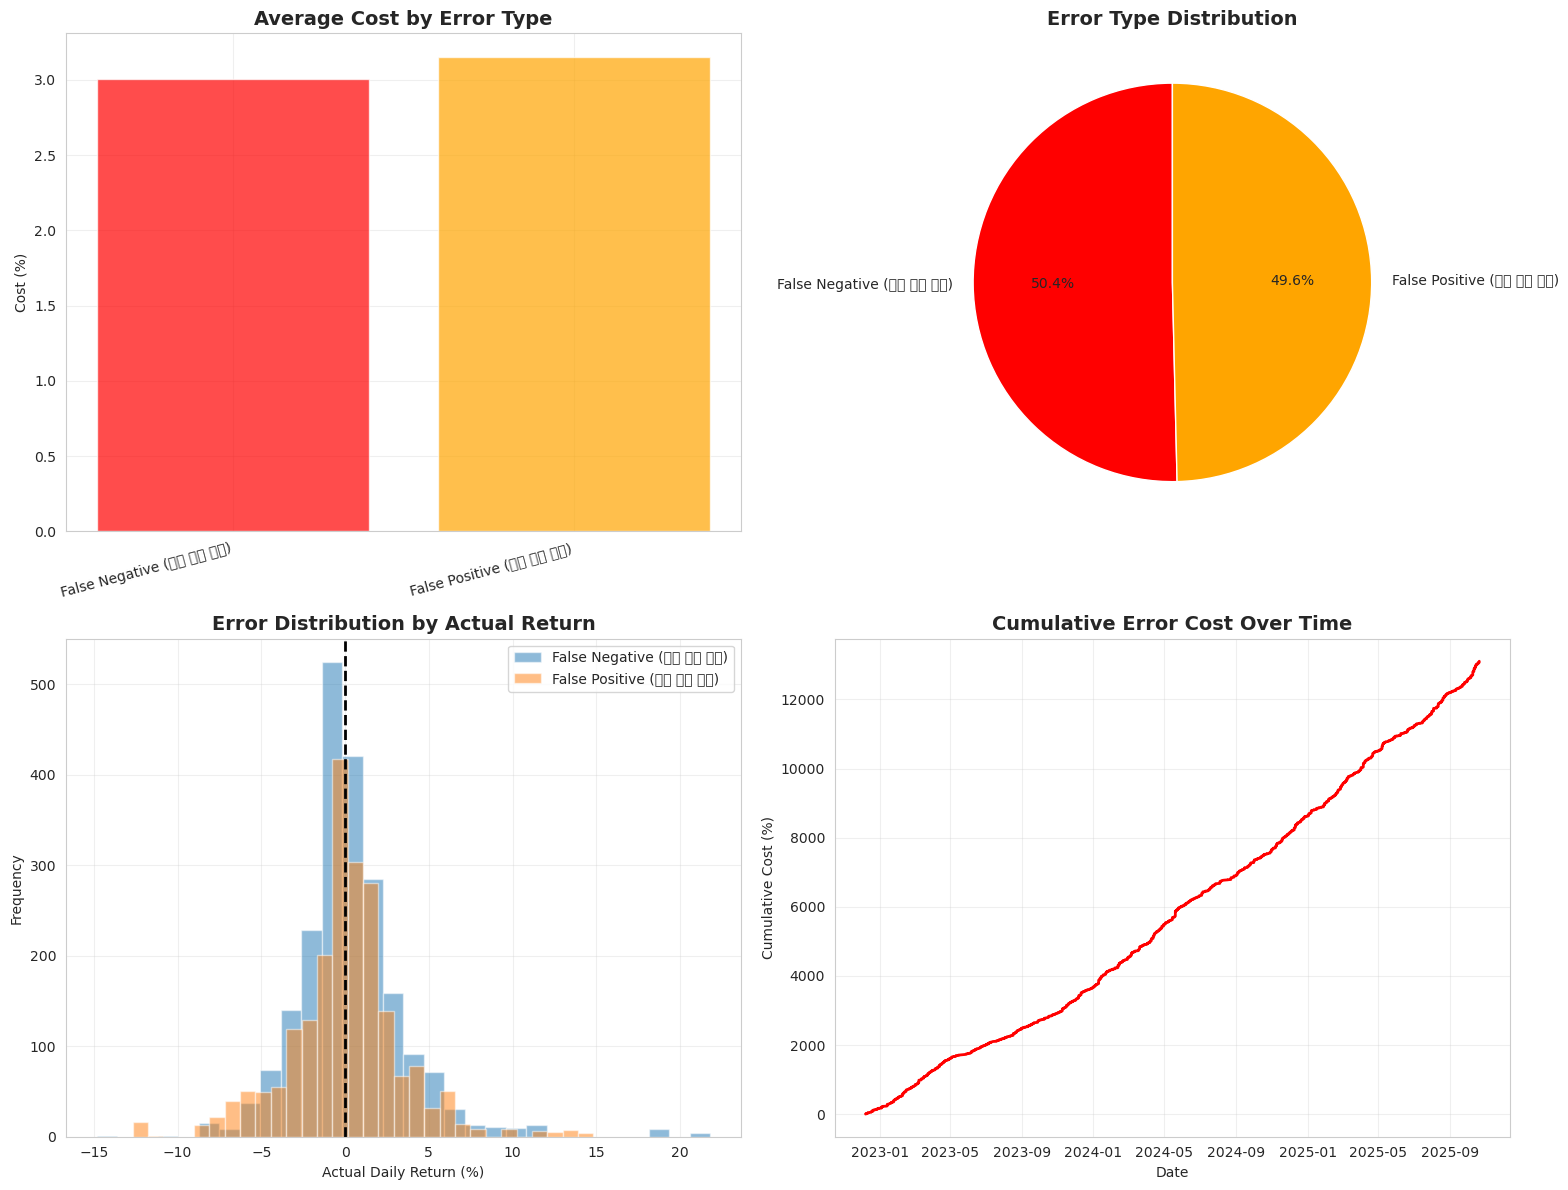

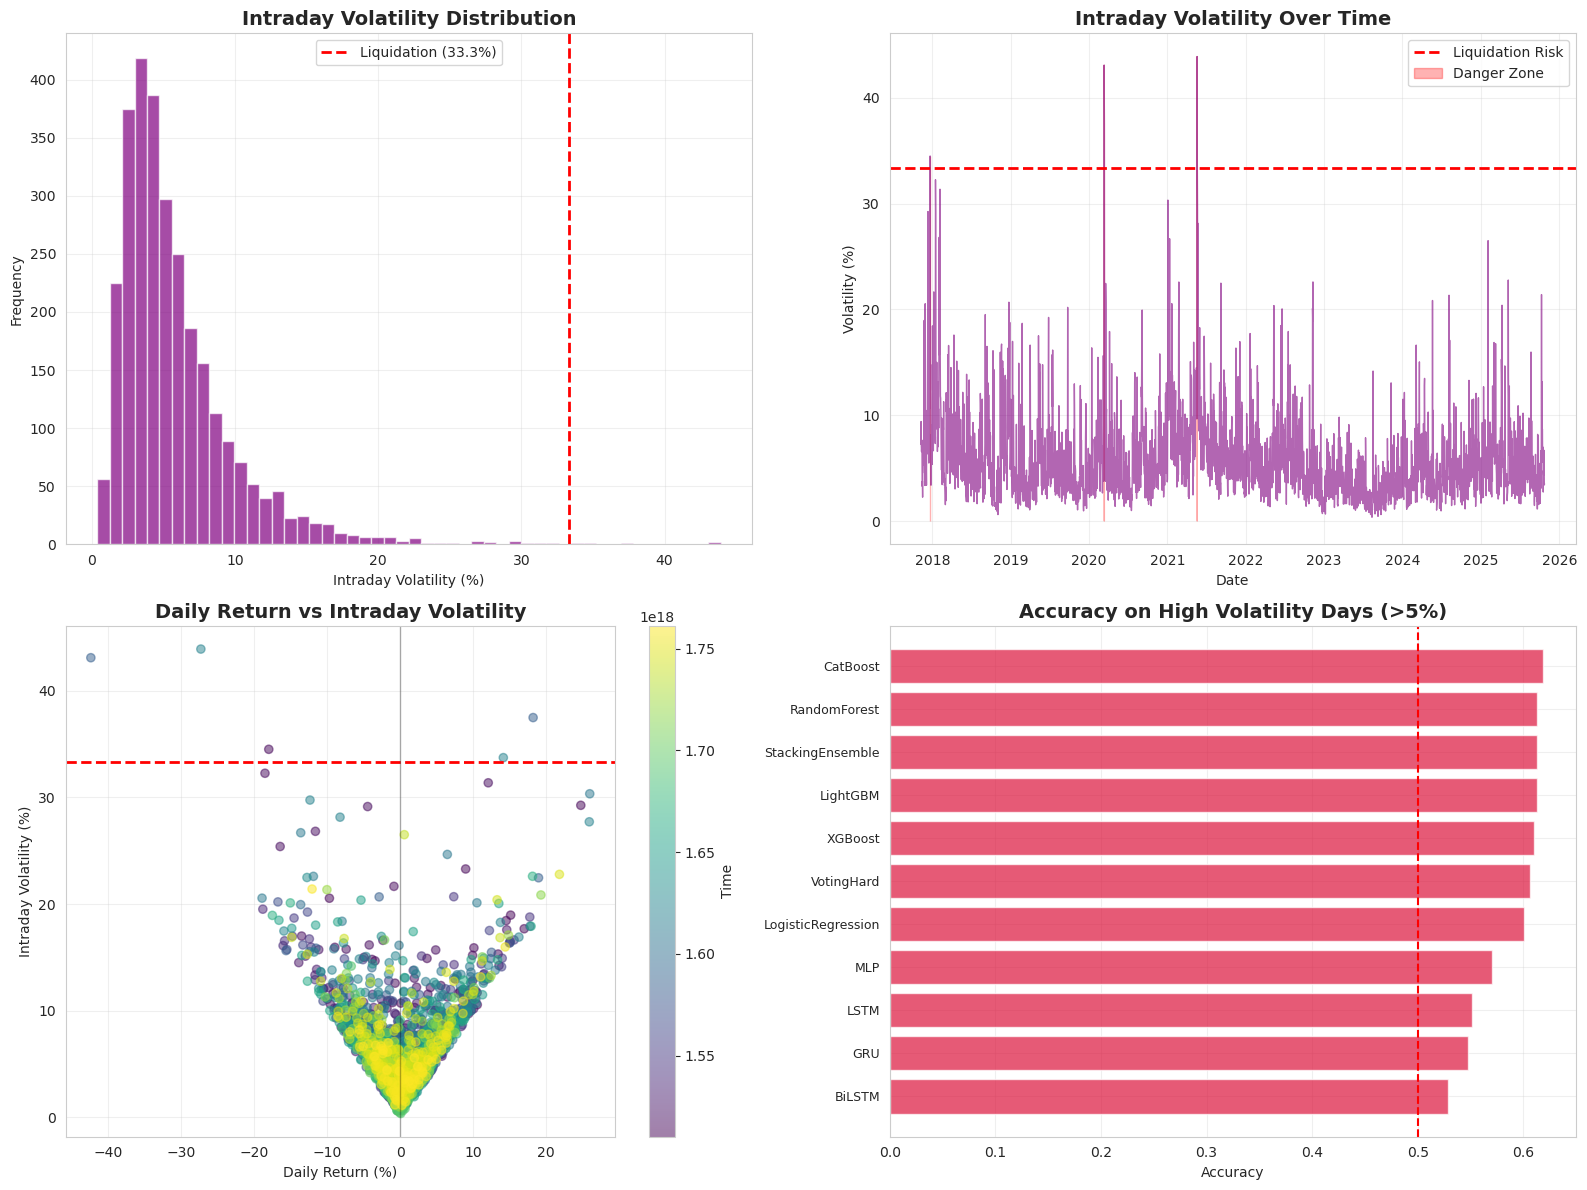

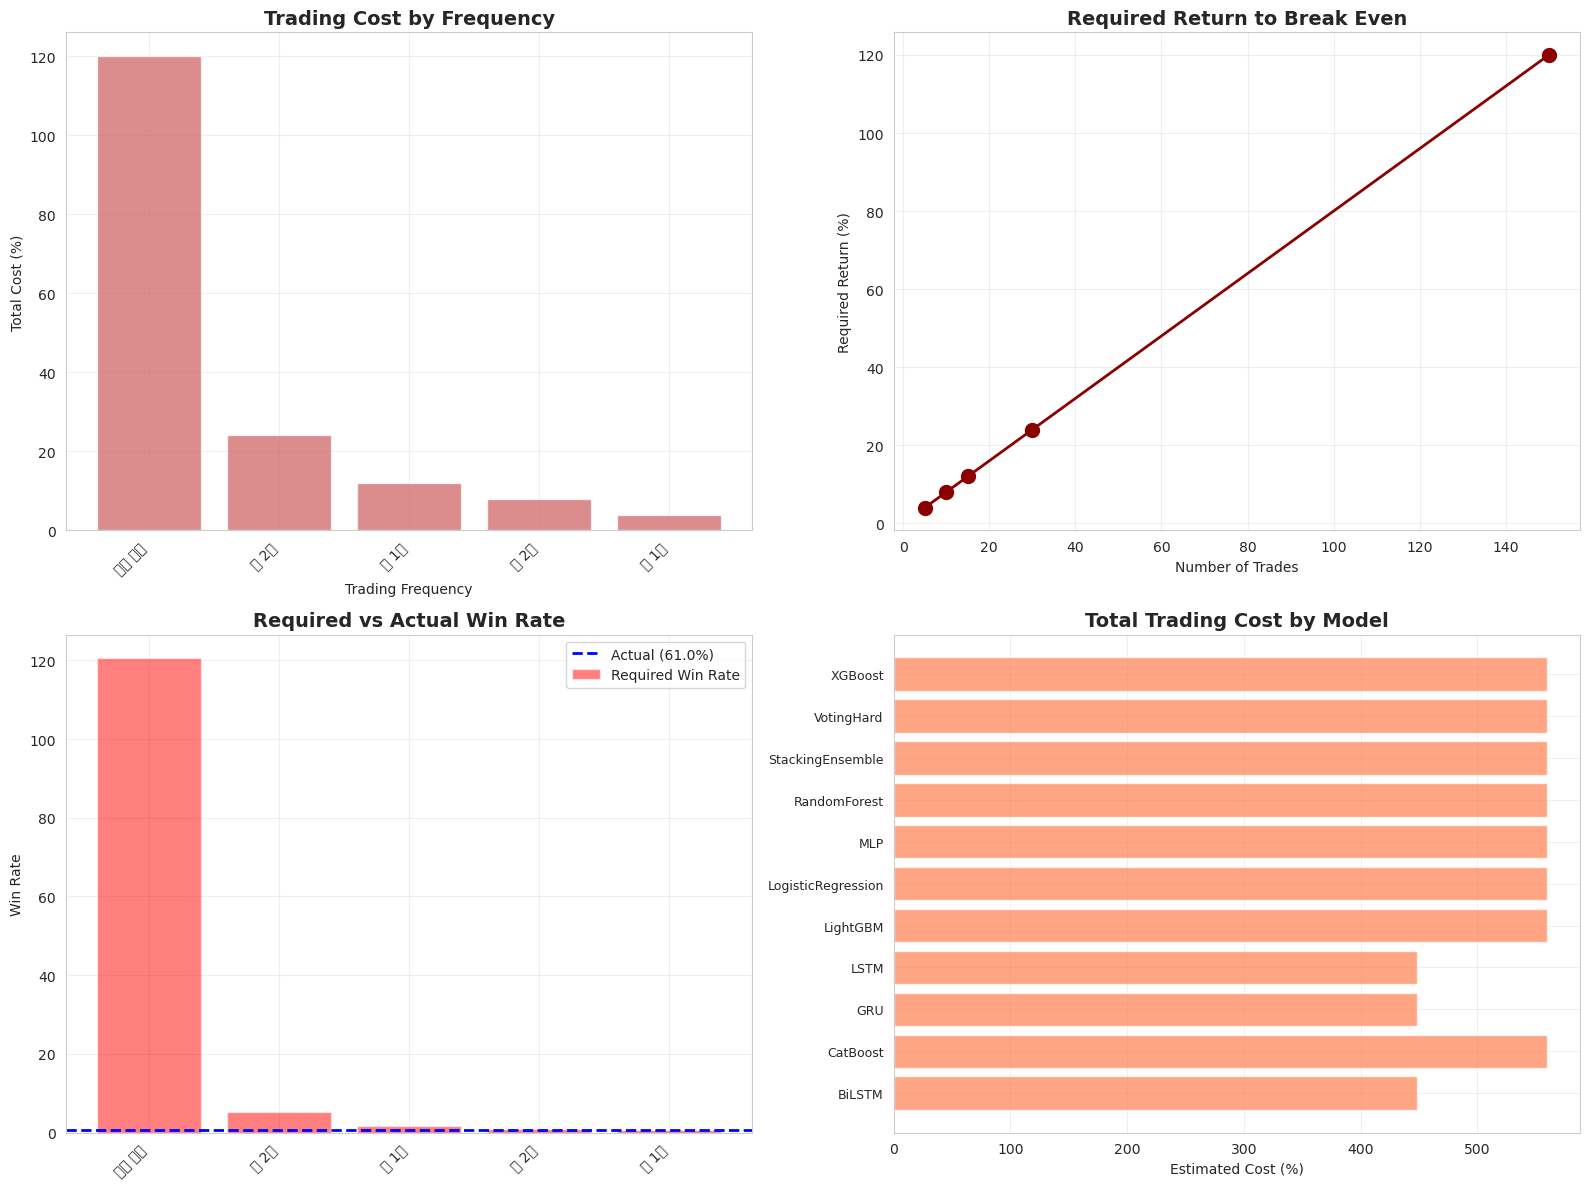

In [5]:
"""
트레이딩 실패 원인 분석 및 시각화
왜 Buy & Hold를 이길 수 없는가?
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (16, 10)
sns.set_style('whitegrid')


class TradingFailureAnalyzer:
    """트레이딩 실패 원인 심층 분석"""
    
    def __init__(self, model_results_base, market_data_path, output_dir):
        self.model_results_base = Path(model_results_base)
        self.market_data_path = Path(market_data_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.fold_info = {
            1: {'test_start': '2022-12-07', 'test_end': '2023-05-05', 'label': 'Fold 1 (Sideways)'},
            2: {'test_start': '2023-05-06', 'test_end': '2023-10-02', 'label': 'Fold 2 (Sideways)'},
            3: {'test_start': '2023-10-03', 'test_end': '2024-02-29', 'label': 'Fold 3 (Bull)'},
            4: {'test_start': '2024-03-01', 'test_end': '2024-07-28', 'label': 'Fold 4 (Bull)'},
            5: {'test_start': '2024-07-29', 'test_end': '2024-12-25', 'label': 'Fold 5 (Bear)'},
            6: {'test_start': '2024-12-26', 'test_end': '2025-05-24', 'label': 'Fold 6 (Bear)'},
            7: {'test_start': '2025-05-25', 'test_end': '2025-10-21', 'label': 'Fold 7 (Bull)'},
            8: {'test_start': '2025-01-01', 'test_end': '2025-10-21', 'label': 'Fold 8 (Mixed)'}
        }
        
        self.models = [
            'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost',
            'LogisticRegression', 'StackingEnsemble', 'VotingHard',
            'MLP', 'LSTM', 'BiLSTM', 'GRU'
        ]
    
    def load_market_data(self):
        """시장 데이터 로드"""
        df = pd.read_csv(self.market_data_path)
        df['date'] = pd.to_datetime(df['date'])
        df['daily_return'] = (df['ETH_Close'] / df['ETH_Open'] - 1) * 100
        df['intraday_volatility'] = ((df['ETH_High'] - df['ETH_Low']) / df['ETH_Open']) * 100
        return df
    
    def load_all_predictions(self):
        """모든 예측 결과 로드"""
        all_data = []
        
        for fold in range(1, 9):
            for model in self.models:
                try:
                    pred_path = (
                        self.model_results_base / 
                        "fold_results/direction" / 
                        f"fold_{fold}_walk_forward_rolling_reverse" / 
                        f"{model}_predictions.csv"
                    )
                    
                    if not pred_path.exists():
                        continue
                    
                    df = pd.read_csv(pred_path)
                    df['date'] = pd.to_datetime(df['date'])
                    df['fold'] = fold
                    df['model'] = model
                    
                    all_data.append(df)
                except Exception as e:
                    print(f"Error loading {model} fold {fold}: {e}")
        
        if not all_data:
            raise ValueError("No prediction data loaded!")
        
        return pd.concat(all_data, ignore_index=True)
    
    def analyze_prediction_accuracy_by_return_magnitude(self):
        """수익률 크기별 예측 정확도 분석"""
        
        print("\n" + "="*80)
        print("분석 1: 수익률 크기별 예측 정확도")
        print("="*80)
        
        preds = self.load_all_predictions()
        market = self.load_market_data()
        
        merged = preds.merge(market[['date', 'daily_return', 'intraday_volatility']], 
                            on='date', how='left')
        
        merged['return_category'] = pd.cut(
            merged['daily_return'],
            bins=[-100, -5, -3, -1, 1, 3, 5, 100],
            labels=['대폭락(<-5%)', '폭락(-5~-3%)', '하락(-3~-1%)', 
                   '횡보(-1~1%)', '상승(1~3%)', '급등(3~5%)', '대급등(>5%)']
        )
        
        accuracy_by_return = merged.groupby('return_category').agg({
            'correct': 'mean',
            'confidence': 'mean',
            'date': 'count'
        }).round(3)
        accuracy_by_return.columns = ['정확도', '평균신뢰도', '거래수']
        
        print("\n수익률 구간별 예측 정확도:")
        print(accuracy_by_return)
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 수익률별 정확도
        ax = axes[0, 0]
        accuracy_by_return['정확도'].plot(kind='bar', ax=ax, color='steelblue')
        ax.axhline(y=0.5, color='red', linestyle='--', label='Random (50%)')
        ax.set_title('Return Magnitude vs Prediction Accuracy', fontsize=14, fontweight='bold')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Return Category')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. 실제 수익률 분포
        ax = axes[0, 1]
        merged['daily_return'].hist(bins=50, ax=ax, color='lightcoral', edgecolor='black')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax.set_title('Daily Return Distribution', fontsize=14, fontweight='bold')
        ax.set_xlabel('Daily Return (%)')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        # 3. 정확도 vs 신뢰도
        ax = axes[1, 0]
        model_stats = merged.groupby('model').agg({
            'correct': 'mean',
            'confidence': 'mean'
        })
        ax.scatter(model_stats['confidence'], model_stats['correct'], s=100, alpha=0.6)
        for idx, row in model_stats.iterrows():
            ax.annotate(idx, (row['confidence'], row['correct']), 
                       fontsize=8, alpha=0.7)
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        ax.set_title('Model Confidence vs Accuracy', fontsize=14, fontweight='bold')
        ax.set_xlabel('Average Confidence')
        ax.set_ylabel('Accuracy')
        ax.grid(True, alpha=0.3)
        
        # 4. Fold별 정확도
        ax = axes[1, 1]
        fold_acc = merged.groupby('fold')['correct'].mean()
        fold_labels = [self.fold_info[f]['label'] for f in fold_acc.index]
        ax.bar(range(len(fold_acc)), fold_acc.values, color='seagreen', alpha=0.7)
        ax.set_xticks(range(len(fold_acc)))
        ax.set_xticklabels(fold_labels, rotation=45, ha='right')
        ax.axhline(y=0.5, color='red', linestyle='--', label='Random')
        ax.set_title('Accuracy by Time Period', fontsize=14, fontweight='bold')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'analysis_1_accuracy_by_return.png', dpi=300, bbox_inches='tight')
        print(f"\n저장: analysis_1_accuracy_by_return.png")
        
        return merged
    
    def analyze_wrong_predictions_cost(self, merged):
        """틀린 예측의 비용 분석"""
        
        print("\n" + "="*80)
        print("분석 2: 틀린 예측의 비용")
        print("="*80)
        
        # 틀린 예측만
        wrong = merged[merged['correct'] == 0].copy()
        
        # 예측 유형별 분류
        wrong['error_type'] = wrong.apply(
            lambda x: 'False Positive (상승 예측 실패)' if x['pred_direction'] == 1 
                     else 'False Negative (하락 예측 실패)', axis=1
        )
        
        # 비용 계산 (수수료 0.8% 포함)
        wrong['cost'] = abs(wrong['daily_return']) + 0.8
        
        error_cost = wrong.groupby('error_type').agg({
            'cost': ['mean', 'sum', 'count'],
            'daily_return': 'mean'
        }).round(2)
        
        print("\n틀린 예측 유형별 비용:")
        print(error_cost)
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 에러 타입별 평균 비용
        ax = axes[0, 0]
        error_avg = wrong.groupby('error_type')['cost'].mean()
        ax.bar(range(len(error_avg)), error_avg.values, 
               color=['red', 'orange'], alpha=0.7)
        ax.set_xticks(range(len(error_avg)))
        ax.set_xticklabels(error_avg.index, rotation=15, ha='right')
        ax.set_title('Average Cost by Error Type', fontsize=14, fontweight='bold')
        ax.set_ylabel('Cost (%)')
        ax.grid(True, alpha=0.3)
        
        # 2. 에러 발생 빈도
        ax = axes[0, 1]
        error_count = wrong.groupby('error_type').size()
        ax.pie(error_count.values, labels=error_count.index, autopct='%1.1f%%',
               colors=['red', 'orange'], startangle=90)
        ax.set_title('Error Type Distribution', fontsize=14, fontweight='bold')
        
        # 3. 수익률별 에러 분포
        ax = axes[1, 0]
        for error_type in wrong['error_type'].unique():
            subset = wrong[wrong['error_type'] == error_type]
            ax.hist(subset['daily_return'], bins=30, alpha=0.5, label=error_type)
        ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax.set_title('Error Distribution by Actual Return', fontsize=14, fontweight='bold')
        ax.set_xlabel('Actual Daily Return (%)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. 누적 에러 비용
        ax = axes[1, 1]
        wrong_sorted = wrong.sort_values('date')
        wrong_sorted['cumulative_cost'] = wrong_sorted['cost'].cumsum()
        ax.plot(wrong_sorted['date'], wrong_sorted['cumulative_cost'], 
               color='red', linewidth=2)
        ax.set_title('Cumulative Error Cost Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Cost (%)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'analysis_2_error_cost.png', dpi=300, bbox_inches='tight')
        print(f"\n저장: analysis_2_error_cost.png")
    
    def analyze_why_liquidation(self, merged):
        """청산 위험 분석"""
        
        print("\n" + "="*80)
        print("분석 3: 청산 위험 분석 (레버리지 3배 가정)")
        print("="*80)
        
        market = self.load_market_data()
        
        # 일중 변동성 분석
        volatility_stats = market['intraday_volatility'].describe()
        print("\n일중 변동성 통계:")
        print(volatility_stats)
        
        # 청산 위험 계산
        leverage = 3
        liquidation_threshold = (1 / leverage) * 100  # 33.3%
        
        # 일중 최대 변동이 청산 기준 초과한 날
        liquidation_days = market[market['intraday_volatility'] > liquidation_threshold]
        
        print(f"\n청산 위험일 수: {len(liquidation_days)}/{len(market)} ({len(liquidation_days)/len(market)*100:.1f}%)")
        print(f"레버리지 3배 기준 청산 임계값: {liquidation_threshold:.1f}%")
        print(f"일중 평균 변동성: {market['intraday_volatility'].mean():.2f}%")
        print(f"일중 최대 변동성: {market['intraday_volatility'].max():.2f}%")
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 일중 변동성 분포
        ax = axes[0, 0]
        market['intraday_volatility'].hist(bins=50, ax=ax, color='purple', alpha=0.7)
        ax.axvline(x=liquidation_threshold, color='red', linestyle='--', 
                  linewidth=2, label=f'Liquidation ({liquidation_threshold:.1f}%)')
        ax.set_title('Intraday Volatility Distribution', fontsize=14, fontweight='bold')
        ax.set_xlabel('Intraday Volatility (%)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. 변동성 시계열
        ax = axes[0, 1]
        ax.plot(market['date'], market['intraday_volatility'], 
               color='purple', alpha=0.6, linewidth=1)
        ax.axhline(y=liquidation_threshold, color='red', linestyle='--', 
                  linewidth=2, label='Liquidation Risk')
        ax.fill_between(market['date'], 0, market['intraday_volatility'], 
                       where=market['intraday_volatility'] > liquidation_threshold,
                       color='red', alpha=0.3, label='Danger Zone')
        ax.set_title('Intraday Volatility Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Volatility (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. 일별 수익률 vs 변동성
        ax = axes[1, 0]
        scatter = ax.scatter(market['daily_return'], market['intraday_volatility'],
                           c=market['date'].astype(int), cmap='viridis', alpha=0.5)
        ax.axhline(y=liquidation_threshold, color='red', linestyle='--', linewidth=2)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax.set_title('Daily Return vs Intraday Volatility', fontsize=14, fontweight='bold')
        ax.set_xlabel('Daily Return (%)')
        ax.set_ylabel('Intraday Volatility (%)')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Time')
        
        # 4. 청산 위험일의 예측 정확도
        ax = axes[1, 1]
        
        high_vol_dates = market[market['intraday_volatility'] > 5]['date']
        high_vol_preds = merged[merged['date'].isin(high_vol_dates)]
        
        if len(high_vol_preds) > 0:
            vol_acc = high_vol_preds.groupby('model')['correct'].mean().sort_values()
            ax.barh(range(len(vol_acc)), vol_acc.values, color='crimson', alpha=0.7)
            ax.set_yticks(range(len(vol_acc)))
            ax.set_yticklabels(vol_acc.index, fontsize=9)
            ax.axvline(x=0.5, color='red', linestyle='--')
            ax.set_title('Accuracy on High Volatility Days (>5%)', 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel('Accuracy')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'analysis_3_liquidation_risk.png', dpi=300, bbox_inches='tight')
        print(f"\n저장: analysis_3_liquidation_risk.png")
    
    def analyze_trading_cost_burden(self, merged):
        """거래 비용 부담 분석"""
        
        print("\n" + "="*80)
        print("분석 4: 거래 비용 부담")
        print("="*80)
        
        # 시뮬레이션: 다양한 거래 빈도
        trading_fee = 0.8  # 0.4% × 2 (왕복)
        
        scenarios = {
            '매일 거래': 150,
            '주 2회': 30,
            '주 1회': 15,
            '월 2회': 10,
            '월 1회': 5
        }
        
        results = []
        for scenario, num_trades in scenarios.items():
            total_cost = num_trades * trading_fee
            
            # 필요 수익률 (수수료 커버)
            required_return = total_cost
            
            results.append({
                'scenario': scenario,
                'trades': num_trades,
                'total_cost': total_cost,
                'required_return': required_return
            })
        
        cost_df = pd.DataFrame(results)
        print("\n거래 빈도별 비용 부담:")
        print(cost_df)
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 거래 빈도별 비용
        ax = axes[0, 0]
        ax.bar(cost_df['scenario'], cost_df['total_cost'], color='indianred', alpha=0.7)
        ax.set_title('Trading Cost by Frequency', fontsize=14, fontweight='bold')
        ax.set_xlabel('Trading Frequency')
        ax.set_ylabel('Total Cost (%)')
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # 2. 필요 수익률
        ax = axes[0, 1]
        ax.plot(cost_df['trades'], cost_df['required_return'], 
               marker='o', linewidth=2, markersize=10, color='darkred')
        ax.set_title('Required Return to Break Even', fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Trades')
        ax.set_ylabel('Required Return (%)')
        ax.grid(True, alpha=0.3)
        
        # 3. 실제 승률과 필요 승률 비교
        ax = axes[1, 0]
        actual_win_rate = merged['correct'].mean()
        
        scenarios_list = list(scenarios.values())
        required_win_rates = [(r / (150 / t)) + 0.5 for t, r in 
                             zip(scenarios_list, cost_df['required_return'])]
        
        x = range(len(scenarios))
        ax.bar(x, required_win_rates, alpha=0.5, label='Required Win Rate', color='red')
        ax.axhline(y=actual_win_rate, color='blue', linestyle='--', 
                  linewidth=2, label=f'Actual ({actual_win_rate:.1%})')
        ax.set_xticks(x)
        ax.set_xticklabels(cost_df['scenario'], rotation=45, ha='right')
        ax.set_title('Required vs Actual Win Rate', fontsize=14, fontweight='bold')
        ax.set_ylabel('Win Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. 모델별 거래 시뮬레이션
        ax = axes[1, 1]
        model_signals = merged.groupby('model').size()
        model_cost = model_signals * (trading_fee / 150) * 100
        
        ax.barh(range(len(model_cost)), model_cost.values, color='coral', alpha=0.7)
        ax.set_yticks(range(len(model_cost)))
        ax.set_yticklabels(model_cost.index, fontsize=9)
        ax.set_title('Total Trading Cost by Model', fontsize=14, fontweight='bold')
        ax.set_xlabel('Estimated Cost (%)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'analysis_4_trading_cost.png', dpi=300, bbox_inches='tight')
        print(f"\n저장: analysis_4_trading_cost.png")
    
    def generate_summary_report(self, merged):
        """종합 리포트 생성"""
        
        print("\n" + "="*80)
        print("종합 분석 리포트")
        print("="*80)
        
        report = []
        
        # 1. 전체 정확도
        overall_acc = merged['correct'].mean()
        report.append(f"\n1. 전체 예측 정확도: {overall_acc:.1%}")
        report.append(f"   - Random 대비: {(overall_acc - 0.5) * 100:+.1f}%p")
        
        # 2. 최고/최저 모델
        model_acc = merged.groupby('model')['correct'].mean().sort_values()
        report.append(f"\n2. 모델별 성능:")
        report.append(f"   - 최고: {model_acc.index[-1]} ({model_acc.iloc[-1]:.1%})")
        report.append(f"   - 최저: {model_acc.index[0]} ({model_acc.iloc[0]:.1%})")
        
        # 3. 실패 원인
        wrong = merged[merged['correct'] == 0]
        avg_wrong_cost = abs(wrong['daily_return']).mean() + 0.8
        
        report.append(f"\n3. 실패 비용:")
        report.append(f"   - 평균 틀린 예측 비용: {avg_wrong_cost:.2f}%")
        report.append(f"   - 틀린 예측 비율: {1 - overall_acc:.1%}")
        report.append(f"   - 총 예상 손실: {avg_wrong_cost * (1 - overall_acc) * 100:.1f}%")
        
        # 4. 거래 비용
        num_signals = len(merged) / 8  # per fold
        trading_cost = num_signals * 0.8
        report.append(f"\n4. 거래 비용:")
        report.append(f"   - 평균 거래 횟수: {num_signals:.0f}회/150일")
        report.append(f"   - 총 거래 비용: {trading_cost:.1f}%")
        
        # 5. 최종 결론
        expected_loss = avg_wrong_cost * (1 - overall_acc) * 100 + trading_cost
        report.append(f"\n5. 예상 손실:")
        report.append(f"   - 틀린 예측 손실: {avg_wrong_cost * (1 - overall_acc) * 100:.1f}%")
        report.append(f"   - 거래 비용: {trading_cost:.1f}%")
        report.append(f"   - 총 예상 손실: {expected_loss:.1f}%")
        report.append(f"\n6. 결론:")
        report.append(f"   → Buy & Hold 대비 {expected_loss:.1f}%p 불리")
        report.append(f"   → 트레이딩으로는 이길 수 없음")
        
        full_report = "\n".join(report)
        print(full_report)
        
        with open(self.output_dir / 'analysis_summary_report.txt', 'w') as f:
            f.write(full_report)
        
        print(f"\n리포트 저장: analysis_summary_report.txt")
    
    def run_all_analysis(self):
        """모든 분석 실행"""
        
        print("="*80)
        print("트레이딩 실패 원인 심층 분석 시작")
        print("="*80)
        
        # 분석 1: 수익률별 정확도
        merged = self.analyze_prediction_accuracy_by_return_magnitude()
        
        # 분석 2: 틀린 예측 비용
        self.analyze_wrong_predictions_cost(merged)
        
        # 분석 3: 청산 위험
        self.analyze_why_liquidation(merged)
        
        # 분석 4: 거래 비용
        self.analyze_trading_cost_burden(merged)
        
        # 종합 리포트
        self.generate_summary_report(merged)
        
        print("\n" + "="*80)
        print("모든 분석 완료!")
        print(f"결과 저장 위치: {self.output_dir}")
        print("="*80)


if __name__ == "__main__":
    analyzer = TradingFailureAnalyzer(
        model_results_base="../model_results/2025-10-26",
        market_data_path="../macro_data/macro_data/macro_crypto_data.csv",
        output_dir="trading_failure_analysis"
    )
    
    analyzer.run_all_analysis()


In [7]:
"""
이더리움 트레이딩 백테스팅 시스템 - 개선 버전
리스크 관리, Anti-Martingale, Kelly Criterion, 드로다운 관리 포함
"""

from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')


@dataclass
class Config:
    market_data_path: Path = Path("../macro_data/macro_data/macro_crypto_data.csv")
    model_results_base: Path = Path("../model_results/2025-10-26")
    output_dir: Path = Path("backtest_results_improved")
    
    folds: List[int] = None
    models: List[str] = None
    position_strategies: List[str] = None
    confidence_thresholds: List[float] = None
    
    # 기본 설정
    initial_capital: float = 1_000_000
    spot_trading_fee: float = 0.004
    spot_slippage: float = 0.0005
    
    # 선물 설정
    futures_leverage: int = 3
    futures_taker_fee: float = 0.0005
    futures_funding_rate: float = 0.0001
    futures_slippage: float = 0.0003
    
    # 리스크 관리 설정 (핵심 개선)
    max_drawdown_limit: float = 0.15  # 15% 드로다운에서 거래 중단
    base_risk_per_trade: float = 0.015  # 단일 거래 기본 리스크 1.5%
    consecutive_loss_threshold: int = 2  # 2회 연속 손실부터 포지션 축소
    
    # Anti-Martingale 설정
    anti_martingale_enabled: bool = True
    loss_position_multiplier: float = 0.5  # 손실 후 포지션 50% 축소
    win_position_multiplier: float = 1.2  # 승리 후 포지션 20% 증가
    max_position_multiplier: float = 2.0  # 최대 포지션 배수
    min_position_multiplier: float = 0.25  # 최소 포지션 배수
    
    # Kelly Criterion 설정
    kelly_enabled: bool = True
    kelly_fraction: float = 0.25  # Quarter Kelly (보수적)
    
    # 변동성 필터
    volatility_filter_enabled: bool = True
    atr_period: int = 14
    min_volatility_percentile: float = 0.25  # 하위 25% 변동성에서는 거래 회피
    
    # 스윙 트레이딩 설정
    swing_entry_confidence: float = 0.30
    swing_stop_loss: float = 0.03
    swing_take_profit: float = 0.15
    swing_max_holding: int = 20
    
    def __post_init__(self):
        if self.folds is None:
            self.folds = list(range(1, 9))
        
        if self.models is None:
            self.models = ['RandomForest', 'LightGBM', 'XGBoost', 'SVM', 'LogisticRegression', 'NaiveBayes', 
                               'KNN', 'AdaBoost', 'CatBoost', 'DecisionTree', 'ExtraTrees', 'Bagging', 
                               'GradientBoosting', 'HistGradientBoosting', 'StackingEnsemble', 'VotingHard', 
                               'VotingSoft', 'MLP', 'LSTM', 'BiLSTM', 'GRU', 'TCN', 'CNN_LSTM', 
                               'LSTM_Attention', 'DTW_LSTM', 'VMD_Hybrid', 'EMD_LSTM', 'Hybrid_LSTM_GRU', 
                               'Residual_LSTM']
        
        if self.position_strategies is None:
            self.position_strategies = ['kelly', 'anti_martingale', 'fixed_risk']
        
        if self.confidence_thresholds is None:
            self.confidence_thresholds = [0.0, 0.2, 0.3]
        
        self.output_dir.mkdir(parents=True, exist_ok=True)


class VolatilityCalculator:
    """ATR 기반 변동성 계산"""
    
    @staticmethod
    def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
        """Average True Range 계산[web:78][web:80]"""
        high = df['ETH_High']
        low = df['ETH_Low']
        close = df['ETH_Close']
        prev_close = close.shift(1)
        
        # True Range 계산
        tr1 = high - low
        tr2 = abs(high - prev_close)
        tr3 = abs(low - prev_close)
        
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        
        # ATR = EMA of True Range
        atr = tr.ewm(span=period, adjust=False).mean()
        
        return atr
    
    @staticmethod
    def calculate_volatility_percentile(atr: pd.Series, window: int = 100) -> pd.Series:
        """현재 변동성의 백분위수 계산"""
        return atr.rolling(window=window, min_periods=20).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        )


class RiskManager:
    """리스크 관리 클래스"""
    
    def __init__(self, config: Config):
        self.config = config
        self.consecutive_losses = 0
        self.consecutive_wins = 0
        self.position_multiplier = 1.0
        self.peak_capital = config.initial_capital
        self.current_drawdown = 0.0
        self.trading_suspended = False
    
    def update_after_trade(self, pnl: float, current_capital: float):
        """거래 후 상태 업데이트"""
        # 드로다운 계산
        self.peak_capital = max(self.peak_capital, current_capital)
        self.current_drawdown = (self.peak_capital - current_capital) / self.peak_capital
        
        # 드로다운 한계 체크
        if self.current_drawdown >= self.config.max_drawdown_limit:
            self.trading_suspended = True
            return
        
        # 연속 손익 추적
        if pnl > 0:
            self.consecutive_wins += 1
            self.consecutive_losses = 0
            if self.config.anti_martingale_enabled:
                self._increase_position()
        else:
            self.consecutive_losses += 1
            self.consecutive_wins = 0
            if self.config.anti_martingale_enabled:
                self._decrease_position()
    
    def _decrease_position(self):
        """Anti-Martingale: 손실 후 포지션 축소[web:74][web:77]"""
        if self.consecutive_losses >= self.config.consecutive_loss_threshold:
            self.position_multiplier *= self.config.loss_position_multiplier
            self.position_multiplier = max(
                self.position_multiplier, 
                self.config.min_position_multiplier
            )
    
    def _increase_position(self):
        """Anti-Martingale: 승리 후 포지션 증가[web:74][web:77]"""
        if self.consecutive_wins >= 2:
            self.position_multiplier *= self.config.win_position_multiplier
            self.position_multiplier = min(
                self.position_multiplier,
                self.config.max_position_multiplier
            )
    
    def get_risk_adjusted_size(self, base_size: float) -> float:
        """리스크 조정된 포지션 크기 반환"""
        if self.trading_suspended:
            return 0.0
        return base_size * self.position_multiplier
    
    def can_trade(self) -> bool:
        """거래 가능 여부"""
        return not self.trading_suspended


class PositionSizer:
    """포지션 사이징 전략"""
    
    @staticmethod
    def calculate(strategy: str, capital: float, confidence: float, 
                 config: Config, win_rate: float = 0.64) -> float:
        """포지션 크기 계산"""
        
        if strategy == 'kelly':
            # Kelly Criterion[web:73][web:76][web:83]
            # f* = (p * b - q) / b, where p=win_rate, q=1-p, b=win/loss ratio
            # 1:1.5 리스크-리워드 가정
            b = 1.5
            p = win_rate
            q = 1 - p
            kelly_fraction = (p * b - q) / b
            kelly_fraction = max(0, kelly_fraction)
            
            # Quarter Kelly로 보수적 접근
            size = capital * kelly_fraction * config.kelly_fraction
            
        elif strategy == 'anti_martingale':
            # Anti-Martingale: 기본 리스크 기반[web:74][web:77]
            size = capital * config.base_risk_per_trade
            
        elif strategy == 'fixed_risk':
            # 고정 리스크: 1.5%
            size = capital * config.base_risk_per_trade
            
        else:
            size = capital * 0.10
        
        # 신뢰도 기반 조정: 높은 확신도에만 큰 포지션
        confidence_multiplier = max(0.5, confidence)
        size *= confidence_multiplier
        
        return size


class DataLoader:
    def __init__(self, config: Config):
        self.config = config
        self.market_data = None
        self.fold_info = {
            1: {'test_start': '2022-12-07', 'test_end': '2023-05-05'},
            2: {'test_start': '2023-05-06', 'test_end': '2023-10-02'},
            3: {'test_start': '2023-10-03', 'test_end': '2024-02-29'},
            4: {'test_start': '2024-03-01', 'test_end': '2024-07-28'},
            5: {'test_start': '2024-07-29', 'test_end': '2024-12-25'},
            6: {'test_start': '2024-12-26', 'test_end': '2025-05-24'},
            7: {'test_start': '2025-05-25', 'test_end': '2025-10-21'},
            8: {'test_start': '2025-01-01', 'test_end': '2025-10-21'}
        }
    
    def load_market_data(self):
        if self.market_data is None:
            df = pd.read_csv(self.config.market_data_path)
            df['date'] = pd.to_datetime(df['date'])
            self.market_data = df[['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close']].copy()
            
            # 변동성 계산 추가
            self.market_data['ATR'] = VolatilityCalculator.calculate_atr(
                self.market_data, self.config.atr_period
            )
            self.market_data['volatility_percentile'] = VolatilityCalculator.calculate_volatility_percentile(
                self.market_data['ATR']
            )
        
        return self.market_data
    
    def get_fold_market_data(self, fold: int):
        market_df = self.load_market_data()
        cfg = self.fold_info[fold]
        start = pd.to_datetime(cfg['test_start'])
        end = pd.to_datetime(cfg['test_end'])
        mask = (market_df['date'] >= start) & (market_df['date'] <= end)
        return market_df[mask].copy().reset_index(drop=True)
    
    def load_predictions(self, fold: int, model: str):
        pred_path = (
            self.config.model_results_base / 
            "fold_results/direction" / 
            f"fold_{fold}_walk_forward_rolling_reverse" / 
            f"{model}_predictions.csv"
        )
        
        if not pred_path.exists():
            raise FileNotFoundError(f"Not found: {pred_path}")
        
        df = pd.read_csv(pred_path)
        df['date'] = pd.to_datetime(df['date'])
        return df[['date', 'pred_direction', 'confidence', 'max_proba']].copy()


class MetricsCalculator:
    @staticmethod
    def calculate(trades, daily_capital, final_capital, initial_capital, 
                 buy_hold_return, strategy_info):
        metrics = strategy_info.copy()
        total_return = (final_capital / initial_capital - 1) * 100
        alpha = total_return - buy_hold_return
        
        trades_with_pnl = [t for t in trades if 'pnl' in t]
        if trades_with_pnl:
            wins = [t for t in trades_with_pnl if t['pnl'] > 0]
            losses = [t for t in trades_with_pnl if t['pnl'] < 0]
            
            win_rate = len(wins) / len(trades_with_pnl) if trades_with_pnl else 0
            avg_win = np.mean([t['pnl'] for t in wins]) if wins else 0
            avg_loss = np.mean([abs(t['pnl']) for t in losses]) if losses else 0
            
            # 리스크-리워드 비율
            risk_reward_ratio = avg_win / avg_loss if avg_loss > 0 else 0
            
            # 기댓값 (Expectancy)
            expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
        else:
            win_rate = 0
            risk_reward_ratio = 0
            expectancy = 0
        
        # 최대 드로다운
        peak = initial_capital
        max_dd = 0
        for capital in daily_capital:
            peak = max(peak, capital)
            if peak > 0:
                dd = (peak - capital) / peak
                max_dd = max(max_dd, dd)
        
        # Sharpe Ratio 근사치 (일별 수익률 기반)
        if len(daily_capital) > 1:
            returns = pd.Series(daily_capital).pct_change().dropna()
            sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        else:
            sharpe = 0
        
        metrics.update({
            'total_return_pct': total_return,
            'alpha_pct': alpha,
            'final_capital': final_capital,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'max_drawdown': max_dd,
            'risk_reward_ratio': risk_reward_ratio,
            'expectancy': expectancy,
            'sharpe_ratio': sharpe
        })
        
        return metrics


class BuyHoldStrategy:
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, fold):
        initial = self.config.initial_capital
        entry_price = market_df.iloc[0]['ETH_Open']
        exit_price = market_df.iloc[-1]['ETH_Close']
        
        fee = initial * self.config.spot_trading_fee
        eth_amount = (initial - fee) / entry_price
        
        final_value = eth_amount * exit_price
        final_fee = final_value * self.config.spot_trading_fee
        final_capital = final_value - final_fee
        
        daily_capital = [eth_amount * p for p in market_df['ETH_Close']]
        
        trades = [{'pnl': final_capital - initial}]
        
        info = {
            'fold': fold,
            'strategy': 'Buy & Hold',
            'model': 'N/A',
            'position_strategy': 'N/A',
            'trading_method': 'buy_hold',
            'confidence_threshold': 0.0
        }
        
        total_return = (final_capital / initial - 1) * 100
        return MetricsCalculator.calculate(
            trades, daily_capital, final_capital, initial, total_return, info
        )


class ImprovedSpotDayTrading:
    """개선된 현물 데이 트레이딩"""
    
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        cash = self.config.initial_capital
        eth = 0
        trades = []
        daily_capital = []
        last_buy = 0
        
        risk_manager = RiskManager(self.config)
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for _, row in merged.iterrows():
            # 변동성 필터: 낮은 변동성에서는 거래 회피
            if (self.config.volatility_filter_enabled and 
                row['volatility_percentile'] < self.config.min_volatility_percentile):
                daily_capital.append(cash + eth * row['ETH_Close'])
                continue
            
            # 신뢰도 필터
            if row['confidence'] < conf_threshold:
                daily_capital.append(cash + eth * row['ETH_Close'])
                continue
            
            # 드로다운 한계 체크
            if not risk_manager.can_trade():
                daily_capital.append(cash + eth * row['ETH_Close'])
                continue
            
            price = row['ETH_Open']
            
            # 매수
            if row['pred_direction'] == 1 and eth == 0:
                base_size = PositionSizer.calculate(
                    pos_strategy, cash, row['confidence'], self.config
                )
                size = risk_manager.get_risk_adjusted_size(base_size)
                
                if size > 0 and size <= cash:
                    fee = size * self.config.spot_trading_fee
                    slippage = size * self.config.spot_slippage
                    eth = (size - fee - slippage) / price
                    cash -= size
                    last_buy = size
            
            # 매도
            elif row['pred_direction'] == 0 and eth > 0:
                value = eth * price
                fee = value * self.config.spot_trading_fee
                slippage = value * self.config.spot_slippage
                net_value = value - fee - slippage
                
                pnl = net_value - last_buy
                cash += net_value
                trades.append({'pnl': pnl})
                eth = 0
                
                # 리스크 매니저 업데이트
                current_capital = cash
                risk_manager.update_after_trade(pnl, current_capital)
            
            daily_capital.append(cash + eth * row['ETH_Close'])
        
        # 남은 포지션 청산
        if eth > 0:
            final_price = merged.iloc[-1]['ETH_Close']
            value = eth * final_price
            fee = value * self.config.spot_trading_fee
            cash += (value - fee)
        
        info = {
            'fold': fold,
            'strategy': 'Improved Spot Day Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'spot_day_improved',
            'confidence_threshold': conf_threshold,
            'max_consecutive_losses': risk_manager.consecutive_losses,
            'trading_suspended': risk_manager.trading_suspended
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, cash, self.config.initial_capital, bh_return, info
        )


class ImprovedSpotSwingTrading:
    """개선된 현물 스윙 트레이딩"""
    
    def __init__(self, config):
        self.config = config
    
    def backtest(self, market_df, pred_df, pos_strategy, model, fold, bh_return, conf_threshold):
        cash = self.config.initial_capital
        eth = 0
        in_position = False
        entry_price = 0
        entry_value = 0
        holding_days = 0
        
        trades = []
        daily_capital = []
        
        risk_manager = RiskManager(self.config)
        
        merged = pred_df.merge(market_df, on='date', how='left')
        
        for idx, row in merged.iterrows():
            # 진입
            if not in_position and risk_manager.can_trade():
                # 변동성 필터
                if (self.config.volatility_filter_enabled and 
                    row['volatility_percentile'] < self.config.min_volatility_percentile):
                    daily_capital.append(cash)
                    continue
                
                # 진입 조건: 높은 확신도 + 상승 예측
                if (row['pred_direction'] == 1 and 
                    row['confidence'] > self.config.swing_entry_confidence):
                    
                    entry_price = row['ETH_Open']
                    base_size = PositionSizer.calculate(
                        pos_strategy, cash, row['confidence'], self.config
                    )
                    size = risk_manager.get_risk_adjusted_size(base_size)
                    
                    if size > 0 and size <= cash:
                        fee = size * self.config.spot_trading_fee
                        slippage = size * self.config.spot_slippage
                        eth = (size - fee - slippage) / entry_price
                        cash -= size
                        entry_value = size
                        in_position = True
                        holding_days = 0
            
            # 청산
            else:
                holding_days += 1
                current_return = (row['ETH_Close'] / entry_price - 1)
                
                # 청산 조건
                should_exit = (
                    current_return <= -self.config.swing_stop_loss or  # 손절
                    current_return >= self.config.swing_take_profit or  # 익절
                    row['pred_direction'] == 0 or  # 하락 예측
                    holding_days >= self.config.swing_max_holding or  # 최대 보유 기간
                    idx == len(merged) - 1  # 마지막 날
                )
                
                if should_exit:
                    exit_price = row['ETH_Close']
                    value = eth * exit_price
                    fee = value * self.config.spot_trading_fee
                    slippage = value * self.config.spot_slippage
                    net_value = value - fee - slippage
                    
                    pnl = net_value - entry_value
                    cash += net_value
                    trades.append({'pnl': pnl})
                    eth = 0
                    in_position = False
                    
                    # 리스크 매니저 업데이트
                    risk_manager.update_after_trade(pnl, cash)
            
            daily_capital.append(cash + eth * row['ETH_Close'])
        
        info = {
            'fold': fold,
            'strategy': 'Improved Spot Swing Trading',
            'model': model,
            'position_strategy': pos_strategy,
            'trading_method': 'spot_swing_improved',
            'confidence_threshold': conf_threshold,
            'max_consecutive_losses': risk_manager.consecutive_losses,
            'trading_suspended': risk_manager.trading_suspended
        }
        
        return MetricsCalculator.calculate(
            trades, daily_capital, cash, self.config.initial_capital, bh_return, info
        )


class BacktestEngine:
    def __init__(self, config):
        self.config = config
        self.data_loader = DataLoader(config)
        self.results = []
    
    def run_all_backtests(self):
        print("="*80)
        print("개선된 백테스팅 시스템 시작")
        print("="*80)
        print(f"\n주요 개선 사항:")
        print(f"  - Kelly Criterion 포지션 사이징")
        print(f"  - Anti-Martingale 연속 손실 대응")
        print(f"  - 최대 드로다운 {self.config.max_drawdown_limit*100}% 한계")
        print(f"  - ATR 기반 변동성 필터링")
        print(f"  - 리스크-리워드 비율 및 기댓값 추적\n")
        
        print(f"Folds: {len(self.config.folds)}")
        print(f"Models: {len(self.config.models)}")
        print(f"Position Strategies: {self.config.position_strategies}")
        print(f"Confidence Thresholds: {self.config.confidence_thresholds}\n")
        
        for fold in self.config.folds:
            print(f"\n{'='*60}")
            print(f"Fold {fold} 처리 중...")
            print(f"{'='*60}")
            
            market_df = self.data_loader.get_fold_market_data(fold)
            
            # Buy & Hold 벤치마크
            buy_hold = BuyHoldStrategy(self.config)
            bh_result = buy_hold.backtest(market_df, fold)
            bh_return = bh_result['total_return_pct']
            self.results.append(bh_result)
            print(f"Buy & Hold: {bh_return:+.2f}%")
            
            for model in self.config.models:
                try:
                    pred_df = self.data_loader.load_predictions(fold, model)
                except FileNotFoundError:
                    continue
                
                print(f"  Model: {model}")
                
                for pos in self.config.position_strategies:
                    for conf in self.config.confidence_thresholds:
                        # 현물 데이 트레이딩
                        spot_day = ImprovedSpotDayTrading(self.config)
                        r = spot_day.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
                        
                        # 현물 스윙 트레이딩
                        spot_swing = ImprovedSpotSwingTrading(self.config)
                        r = spot_swing.backtest(market_df, pred_df, pos, model, fold, bh_return, conf)
                        self.results.append(r)
            
            print(f"Fold {fold} 완료")
        
        print("\n" + "="*80)
        print("백테스팅 완료")
        print("="*80)
        self.save_results()
        self.analyze_results()
    
    def save_results(self):
        df = pd.DataFrame(self.results)
        output_path = self.config.output_dir / 'backtest_results_improved.csv'
        df.to_csv(output_path, index=False)
        print(f"\n결과 저장: {output_path}")
    
    def analyze_results(self):
        df = pd.DataFrame(self.results)
        
        print("\n" + "="*80)
        print("개선된 백테스팅 결과 분석")
        print("="*80)
        
        bh = df[df['strategy'] == 'Buy & Hold']['total_return_pct'].mean()
        print(f"\n1. Buy & Hold 벤치마크: {bh:+.2f}%")
        
        trading = df[df['strategy'] != 'Buy & Hold'].copy()
        
        print(f"\n2. 전체 트레이딩 전략 성과:")
        print(f"   - 평균 Alpha: {trading['alpha_pct'].mean():+.2f}%")
        print(f"   - Alpha > 0: {(trading['alpha_pct'] > 0).sum()}/{len(trading)} ({(trading['alpha_pct'] > 0).mean()*100:.1f}%)")
        print(f"   - 평균 승률: {trading['win_rate'].mean()*100:.1f}%")
        print(f"   - 평균 리스크-리워드: {trading['risk_reward_ratio'].mean():.2f}")
        print(f"   - 평균 Sharpe Ratio: {trading['sharpe_ratio'].mean():.2f}")
        
        print(f"\n3. 포지션 전략별 성과:")
        by_pos = trading.groupby('position_strategy').agg({
            'alpha_pct': 'mean',
            'win_rate': 'mean',
            'risk_reward_ratio': 'mean',
            'max_drawdown': 'mean'
        }).round(3)
        print(by_pos)
        
        print(f"\n4. 거래 방식별 성과:")
        by_method = trading.groupby('trading_method').agg({
            'alpha_pct': 'mean',
            'num_trades': 'mean',
            'win_rate': 'mean',
            'expectancy': 'mean'
        }).sort_values('alpha_pct', ascending=False).round(3)
        print(by_method)
        
        print(f"\n5. 상위 10개 전략:")
        best = trading.nlargest(10, 'alpha_pct')
        print(best[['fold', 'model', 'position_strategy', 'confidence_threshold', 
                   'alpha_pct', 'win_rate', 'risk_reward_ratio', 'num_trades', 
                   'max_drawdown']].to_string(index=False))
        
        print(f"\n6. 드로다운 관리 효과:")
        suspended = trading[trading.get('trading_suspended', False) == True]
        print(f"   - 거래 중단된 경우: {len(suspended)}/{len(trading)} ({len(suspended)/len(trading)*100:.1f}%)")
        print(f"   - 평균 최대 드로다운: {trading['max_drawdown'].mean()*100:.1f}%")


if __name__ == "__main__":
    config = Config()
    engine = BacktestEngine(config)
    engine.run_all_backtests()


개선된 백테스팅 시스템 시작

주요 개선 사항:
  - Kelly Criterion 포지션 사이징
  - Anti-Martingale 연속 손실 대응
  - 최대 드로다운 15.0% 한계
  - ATR 기반 변동성 필터링
  - 리스크-리워드 비율 및 기댓값 추적

Folds: 8
Models: 29
Position Strategies: ['kelly', 'anti_martingale', 'fixed_risk']
Confidence Thresholds: [0.0, 0.2, 0.3]


Fold 1 처리 중...
Buy & Hold: +55.65%
  Model: RandomForest
  Model: LightGBM
  Model: XGBoost
  Model: SVM
  Model: LogisticRegression
  Model: NaiveBayes
  Model: KNN
  Model: AdaBoost
  Model: CatBoost
  Model: DecisionTree
  Model: ExtraTrees
  Model: Bagging
  Model: GradientBoosting
  Model: HistGradientBoosting
  Model: StackingEnsemble
  Model: VotingHard
  Model: VotingSoft
  Model: MLP
  Model: LSTM
  Model: BiLSTM
  Model: GRU
  Model: TCN
  Model: CNN_LSTM
  Model: LSTM_Attention
  Model: DTW_LSTM
  Model: VMD_Hybrid
  Model: EMD_LSTM
  Model: Hybrid_LSTM_GRU
  Model: Residual_LSTM
Fold 1 완료

Fold 2 처리 중...
Buy & Hold: -17.30%
  Model: RandomForest
  Model: LightGBM
  Model: XGBoost
  Model: SVM
  Model: Log